In [1]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from src.utils.data_loader import LoadDataSet, CustomDataSet
from src.positioning.toa import toa_positioning
from src.utils.models import DenseNet
from sklearn.decomposition import PCA
from torchsummary import summary
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import tikzplotlib
import torch
import os
%matplotlib inline
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### PCA Analysis

#### PCA with All Features Data
In this case we consider the data associated with each path, BS, and charcteristic (the 6 features for each path) as a unique set of features of dimension 600.

In [2]:
# Load the dataset with all the paths
dir_name = "Omni Spatial and Temporal Data/"
all_paths_dataset = LoadDataSet(dir_name, path_mode="all_paths")
print(f"Random shuffling state: {all_paths_dataset.rnd_state}")
scaler = StandardScaler()
train_set, test_set = all_paths_dataset.get_datasets(scale=True, scaler=scaler)
train_dl = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_set, batch_size=1024, shuffle=False)

54582
The shape of the feature data is (150000, 4, 25, 6)
The shape of the target data is: (150000, 3)
Random shuffling state: 3
The shape of the training data is: (75000, 4, 25, 6)
The shape of the testing data is: (75000, 4, 25, 6)
new training shape: (75000, 600)


In [3]:
# create the sk-learn PCA object and fit the training data
pca_all = PCA()
pca_all_components = pca_all.fit(train_set.X)

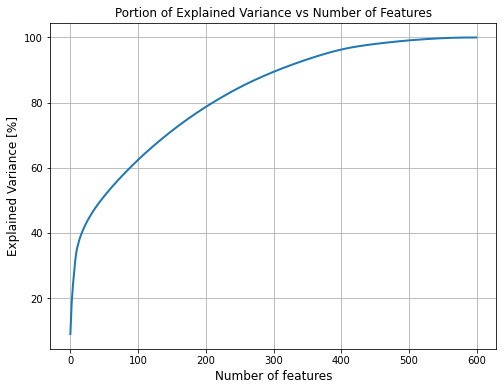

In [4]:
# let's visualize the amount of explained variance by increasing number of considered features
cum_explained_var = np.cumsum(pca_all_components.explained_variance_ratio_ * 100)
plt.figure(figsize=(8,6))
plt.plot(cum_explained_var, linewidth=2)
plt.xlabel("Number of features", fontsize=12)
plt.ylabel("Explained Variance [%]", fontsize=12)
plt.title("Portion of Explained Variance vs Number of Features")
plt.grid()

tikzplotlib.save("./figures/explained_variance.tex")

In [5]:
# retain a number of features with which we can explain at least 95 % of the total variance
I = np.where(cum_explained_var >= 95)[0]
num_features_95 = I[0]
print(f"The number of features needed to explain 95 % of the variance is: {num_features_95}")

# create an sk-learn PCA object with the above number of components
pca_95 = PCA(n_components=I[0])
x_train_95 = pca_95.fit_transform(train_set.X)
x_test_95 = pca_95.transform(test_set.X)
print(f"The reduced training data has shape: {x_train_95.shape}")
print(f"The percentage of explained variance is: {np.sum(pca_95.explained_variance_ratio_)*100}")

# create data loaders with the nre reduced data
train_95_dl = torch.utils.data.DataLoader(CustomDataSet(x_train_95, train_set.y), batch_size=32, shuffle=True)
test_95_dl = torch.utils.data.DataLoader(CustomDataSet(x_test_95, test_set.y), batch_size=1024, shuffle=False)

The number of features needed to explain 95 % of the variance is: 377
The reduced training data has shape: (75000, 377)
The percentage of explained variance is: 94.89240049373244


#### PCA for each feature
In this case we consider the data associated with the 6 features (delay, rx power, and the 4 angles of arrival and departure).
Specifically, based on the PCA of the data matrix, we select the 3 features that have the highest explanation power in the dataset. Each feature has 100 singular values associated (25 paths x 4 Base Stations)

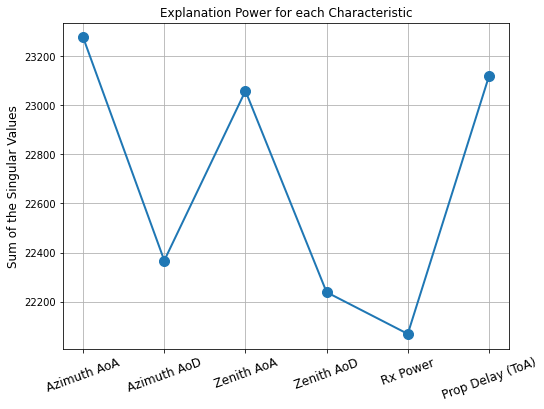

In [6]:
# we consider a PCA with 1 Principal Component to obtain the importance associated whith each characteristic
num_charac = 6
sinv_charac = np.zeros((num_charac, 1))
for i in range(num_charac):
    data = train_set.X[:, i*100:(i+1)*100]
    pca_i = PCA(100)
    pca_i_comp = pca_i.fit(data)
    sinv_charac[i] = np.sum(pca_i_comp.singular_values_)
    
plt.figure(figsize=(8,6))
plt.plot(sinv_charac, '-o', markersize=10, linewidth=2)
plt.ylabel("Sum of the Singular Values", fontsize=12)
plt.grid()
plt.title("Explanation Power for each Characteristic")
plt.xticks(np.arange(6), ["Azimuth AoA","Azimuth AoD","Zenith AoA","Zenith AoD","Rx Power","Prop Delay (ToA)"], rotation=20, fontsize=12)

tikzplotlib.save("./figures/characteristics.tex")

From the plot above we can see that the 3 most important features are: Zenith AoD, Rx Power, and Propagation Delay.
Therefore, we will consider as input to our models the 100 samples (25x4) associated with these 3 characteristics, for a total of 300 features.

In [7]:
# get the full dataset
dir_name = "Omni Spatial and Temporal Data/"
full_dataset = LoadDataSet(dir_name, path_mode="all_paths")
print(f"Random shuffling state: {all_paths_dataset.rnd_state}")
scaler = StandardScaler()
(x_train, y_train), (x_test, y_test) = full_dataset.get_datasets(get_full_data=True)

# selecting the feature corresponding to zenith AoD, Rx Power, and Propagation Delay (ToA) 
# [last 3 indexes in the right-most dimension]
x_train = np.reshape(x_train[:,:,:,[0,2,5]], (x_train.shape[0],x_train.shape[1]*x_train.shape[2]*3))
x_test = np.reshape(x_test[:,:,:,[0,2,5]], (x_test.shape[0],x_test.shape[1]*x_test.shape[2]*3))
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test) 
train_set = CustomDataSet(x_train, y_train)
test_set = CustomDataSet(x_test, y_test)

train_feature_based_dl = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_feature_based_dl = torch.utils.data.DataLoader(test_set, batch_size=1024, shuffle=False)

54582
The shape of the feature data is (150000, 4, 25, 6)
The shape of the target data is: (150000, 3)
Random shuffling state: 3
The shape of the training data is: (75000, 4, 25, 6)
The shape of the testing data is: (75000, 4, 25, 6)


## Train with the 95% variance explained features

In [8]:
in_dim = num_features_95
out_dim = all_paths_dataset.output_shape
layers_dim = [in_dim, 256, 64, out_dim]
dnn_model_95 = DenseNet(layers_dim)
dnn_model_95.to(device)
summary(dnn_model_95, input_data=(1,in_dim), device=device, depth=len(layers_dim))

Loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(dnn_model_95.parameters(), lr=0.0001, amsgrad=False)

Layer (type:depth-idx)                   Output Shape              Param #
├─ModuleList: 1                          []                        --
|    └─Linear: 2-1                       [-1, 1, 256]              96,768
|    └─Linear: 2-2                       [-1, 1, 64]               16,448
|    └─Linear: 2-3                       [-1, 1, 3]                195
Total params: 113,411
Trainable params: 113,411
Non-trainable params: 0
Total mult-adds (M): 0.11
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.43
Estimated Total Size (MB): 0.44


In [9]:
# train the model
train_loss_history = []
test_loss_history = []
n_epochs = 500

for epoch in range(n_epochs):
    total_train_loss = 0
    total_test_loss = 0
    total_train = 0
    total_test = 0

    # training loop (iterate over the training set)
    for x, y in train_95_dl:
        x_train, y_train = x.float().to(device), y.float().to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        train_output = dnn_model_95(x_train) # network output
        loss = Loss(train_output, y_train) # compute loss
        loss.backward() # compute gradient with respect to trainable parameters
        optimizer.step() # weights update
        total_train_loss += loss.item()
        total_train += 1

    print(f"Training at epoch: {epoch+1} ended, Loss: {total_train_loss/total_train}")
    # append training loss for the epoch
    train_loss_history.append(total_train_loss/total_train)

    # testing every 10 training epochs
    if ((epoch+1) % 10) == 0:
        for x, y in test_95_dl:
            x_test, y_test = x.float().to(device), y.float().to(device)
            test_output = dnn_model_95(x_test)
            loss = Loss(test_output, y_test)
            total_test_loss += loss.item()
            total_test += 1
        print(f"--> Testing at epoch: {epoch+1} ended, Loss: {total_test_loss/total_test}")
        # append test loss for the epoch
        test_loss_history.append(total_test_loss/total_test)

print('Finished Training')

Training at epoch: 1 ended, Loss: 10240.059290029896
Training at epoch: 2 ended, Loss: 273.0778702289985
Training at epoch: 3 ended, Loss: 127.30433445172098
Training at epoch: 4 ended, Loss: 81.08409538773546
Training at epoch: 5 ended, Loss: 56.116212931916166
Training at epoch: 6 ended, Loss: 41.06877532713242
Training at epoch: 7 ended, Loss: 31.20375786584392
Training at epoch: 8 ended, Loss: 24.463682574216822
Training at epoch: 9 ended, Loss: 19.599121010547613
Training at epoch: 10 ended, Loss: 15.84546374094771
--> Testing at epoch: 10 ended, Loss: 19.470643198167956
Training at epoch: 11 ended, Loss: 13.23001884366465
Training at epoch: 12 ended, Loss: 11.059113819749689
Training at epoch: 13 ended, Loss: 9.430035506905956
Training at epoch: 14 ended, Loss: 8.16970192328248
Training at epoch: 15 ended, Loss: 7.037814605663254
Training at epoch: 16 ended, Loss: 6.195782375976494
Training at epoch: 17 ended, Loss: 5.501965807668178
Training at epoch: 18 ended, Loss: 4.851251246

Training at epoch: 139 ended, Loss: 0.4849985232290656
Training at epoch: 140 ended, Loss: 0.663709780859281
--> Testing at epoch: 140 ended, Loss: 3.269876443051003
Training at epoch: 141 ended, Loss: 0.6116443226374558
Training at epoch: 142 ended, Loss: 0.4383018727131417
Training at epoch: 143 ended, Loss: 0.4724286552518606
Training at epoch: 144 ended, Loss: 0.5881439390347527
Training at epoch: 145 ended, Loss: 0.5109174407115874
Training at epoch: 146 ended, Loss: 0.4239172729100943
Training at epoch: 147 ended, Loss: 0.5391441568280904
Training at epoch: 148 ended, Loss: 0.4920458280427362
Training at epoch: 149 ended, Loss: 0.5556394321138338
Training at epoch: 150 ended, Loss: 0.4474086602450485
--> Testing at epoch: 150 ended, Loss: 3.277829363539412
Training at epoch: 151 ended, Loss: 0.5504764422914172
Training at epoch: 152 ended, Loss: 0.45470622620535794
Training at epoch: 153 ended, Loss: 0.5090334481740872
Training at epoch: 154 ended, Loss: 0.5939397928098363
Traini

Training at epoch: 273 ended, Loss: 0.2849604036379288
Training at epoch: 274 ended, Loss: 0.29532613810278957
Training at epoch: 275 ended, Loss: 0.37577445445258056
Training at epoch: 276 ended, Loss: 0.3653232235026009
Training at epoch: 277 ended, Loss: 0.29948624965350173
Training at epoch: 278 ended, Loss: 0.375628691281068
Training at epoch: 279 ended, Loss: 0.275683627517913
Training at epoch: 280 ended, Loss: 0.38124305380145945
--> Testing at epoch: 280 ended, Loss: 2.967609987065599
Training at epoch: 281 ended, Loss: 0.29790951778044217
Training at epoch: 282 ended, Loss: 0.31025217066808214
Training at epoch: 283 ended, Loss: 0.4056644568810996
Training at epoch: 284 ended, Loss: 0.2347445931927692
Training at epoch: 285 ended, Loss: 0.38016714294418796
Training at epoch: 286 ended, Loss: 0.3160625103695808
Training at epoch: 287 ended, Loss: 0.3342650324271502
Training at epoch: 288 ended, Loss: 0.33650106380442507
Training at epoch: 289 ended, Loss: 0.36142659919183867
T

Training at epoch: 408 ended, Loss: 0.26827071135571234
Training at epoch: 409 ended, Loss: 0.22711803526665264
Training at epoch: 410 ended, Loss: 0.2265488394590114
--> Testing at epoch: 410 ended, Loss: 2.9204587388683008
Training at epoch: 411 ended, Loss: 0.28551360097659734
Training at epoch: 412 ended, Loss: 0.24985181375600576
Training at epoch: 413 ended, Loss: 0.2638784715152463
Training at epoch: 414 ended, Loss: 0.24174716480317884
Training at epoch: 415 ended, Loss: 0.29113452951980073
Training at epoch: 416 ended, Loss: 0.21734453383324598
Training at epoch: 417 ended, Loss: 0.2942041613911708
Training at epoch: 418 ended, Loss: 0.21480699149262375
Training at epoch: 419 ended, Loss: 0.27239522342681377
Training at epoch: 420 ended, Loss: 0.24497780938864822
--> Testing at epoch: 420 ended, Loss: 3.0106528900765084
Training at epoch: 421 ended, Loss: 0.23261994282864415
Training at epoch: 422 ended, Loss: 0.26949032829317926
Training at epoch: 423 ended, Loss: 0.271413780

In [10]:
torch.save(dnn_model_95.state_dict(), "../models/dnn_model_95_v1")

In [11]:
in_dim = num_features_95
out_dim = all_paths_dataset.output_shape
layers_dim = [in_dim, 256, 64, out_dim]
dnn_model_95 = DenseNet(layers_dim)
dnn_model_95.to(device)
dnn_model_95.load_state_dict(torch.load("../models/dnn_model_95_v1"))

# evaluate the model over the entire data and the test data
train_error_95 = []
test_error_95 = []
all_error_95 = []

for xx, yy in train_95_dl:
    x_to_pred, y_true = xx.float().to(device), yy.float().to(device)
    pred = dnn_model_95(x_to_pred)
    error = torch.sqrt(torch.sum((y_true - pred)**2, dim=1)).to("cpu").detach().numpy()
    train_error_95.extend(error)
    all_error_95.extend(error)

for xx, yy in test_95_dl:
    x_to_pred, y_true = xx.float().to(device), yy.float().to(device)
    pred = dnn_model_95(x_to_pred)
    error = torch.sqrt(torch.sum((y_true - pred)**2, dim=1)).to("cpu").detach().numpy()
    all_error_95.extend(error)
    test_error_95.extend(error)

train_error_95 = np.array(train_error_95)
test_error_95 = np.array(test_error_95)
all_error_95 = np.array(all_error_95)

## Train over the 3 most relevant carachteristics

In [12]:
in_dim = 300
out_dim = all_paths_dataset.output_shape
layers_dim = [in_dim, 256, 64, out_dim]
dnn_model_3 = DenseNet(layers_dim)
dnn_model_3.to(device)
summary(dnn_model_3, input_data=(1,in_dim), device=device, depth=len(layers_dim))

Loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(dnn_model_3.parameters(), lr=0.0001, amsgrad=False)

Layer (type:depth-idx)                   Output Shape              Param #
├─ModuleList: 1                          []                        --
|    └─Linear: 2-1                       [-1, 1, 256]              77,056
|    └─Linear: 2-2                       [-1, 1, 64]               16,448
|    └─Linear: 2-3                       [-1, 1, 3]                195
Total params: 93,699
Trainable params: 93,699
Non-trainable params: 0
Total mult-adds (M): 0.09
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.36
Estimated Total Size (MB): 0.36


In [13]:
# train the model
train_loss_history = []
test_loss_history = []
n_epochs = 500

for epoch in range(n_epochs):
    total_train_loss = 0
    total_test_loss = 0
    total_train = 0
    total_test = 0

    # training loop (iterate over the training set)
    for x, y in train_feature_based_dl:
        x_train, y_train = x.float().to(device), y.float().to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        train_output = dnn_model_3(x_train) # network output
        loss = Loss(train_output, y_train) # compute loss
        loss.backward() # compute gradient with respect to trainable parameters
        optimizer.step() # weights update
        total_train_loss += loss.item()
        total_train += 1

    print(f"Training at epoch: {epoch+1} ended, Loss: {total_train_loss/total_train}")
    # append training loss for the epoch
    train_loss_history.append(total_train_loss/total_train)

    # testing every 10 training epochs
    if ((epoch+1) % 10) == 0:
        for x, y in test_feature_based_dl:
            x_test, y_test = x.float().to(device), y.float().to(device)
            test_output = dnn_model_3(x_test)
            loss = Loss(test_output, y_test)
            total_test_loss += loss.item()
            total_test += 1
        print(f"--> Testing at epoch: {epoch+1} ended, Loss: {total_test_loss/total_test}")
        # append test loss for the epoch
        test_loss_history.append(total_test_loss/total_test)

print('Finished Training')

Training at epoch: 1 ended, Loss: 6335.178031335512
Training at epoch: 2 ended, Loss: 649.6307937439798
Training at epoch: 3 ended, Loss: 395.05658068998684
Training at epoch: 4 ended, Loss: 275.40674243445284
Training at epoch: 5 ended, Loss: 207.51849184264094
Training at epoch: 6 ended, Loss: 164.466558876298
Training at epoch: 7 ended, Loss: 132.80816522311838
Training at epoch: 8 ended, Loss: 110.43186188720598
Training at epoch: 9 ended, Loss: 92.30333249642173
Training at epoch: 10 ended, Loss: 78.08151124850068
--> Testing at epoch: 10 ended, Loss: 74.86380020347801
Training at epoch: 11 ended, Loss: 66.95474862482767
Training at epoch: 12 ended, Loss: 57.36061912510582
Training at epoch: 13 ended, Loss: 50.20934159438358
Training at epoch: 14 ended, Loss: 43.511594746706834
Training at epoch: 15 ended, Loss: 38.59419536102347
Training at epoch: 16 ended, Loss: 33.75562645876367
Training at epoch: 17 ended, Loss: 29.8886396608255
Training at epoch: 18 ended, Loss: 26.3948445332

Training at epoch: 140 ended, Loss: 0.6269719290829966
--> Testing at epoch: 140 ended, Loss: 1.9572206655064144
Training at epoch: 141 ended, Loss: 0.6102992306199598
Training at epoch: 142 ended, Loss: 0.5898232119278696
Training at epoch: 143 ended, Loss: 0.5988675580763675
Training at epoch: 144 ended, Loss: 0.5966485371501677
Training at epoch: 145 ended, Loss: 0.6222281707228248
Training at epoch: 146 ended, Loss: 0.6032503156417364
Training at epoch: 147 ended, Loss: 0.5841454823371086
Training at epoch: 148 ended, Loss: 0.6354858015787886
Training at epoch: 149 ended, Loss: 0.5482653737475034
Training at epoch: 150 ended, Loss: 0.5585493234784021
--> Testing at epoch: 150 ended, Loss: 2.215452529288627
Training at epoch: 151 ended, Loss: 0.5748737282962014
Training at epoch: 152 ended, Loss: 0.5703034118301022
Training at epoch: 153 ended, Loss: 0.4897106117711946
Training at epoch: 154 ended, Loss: 0.5973182564518659
Training at epoch: 155 ended, Loss: 0.5659120610308016
Train

Training at epoch: 274 ended, Loss: 0.25242578503977725
Training at epoch: 275 ended, Loss: 0.2755018070470478
Training at epoch: 276 ended, Loss: 0.26799867084446927
Training at epoch: 277 ended, Loss: 0.2466673625652192
Training at epoch: 278 ended, Loss: 0.26794648377396446
Training at epoch: 279 ended, Loss: 0.24400704732933956
Training at epoch: 280 ended, Loss: 0.25725678810309427
--> Testing at epoch: 280 ended, Loss: 1.7469557145157375
Training at epoch: 281 ended, Loss: 0.2576641505997336
Training at epoch: 282 ended, Loss: 0.2639055813061957
Training at epoch: 283 ended, Loss: 0.27919739254340276
Training at epoch: 284 ended, Loss: 0.22472200517259766
Training at epoch: 285 ended, Loss: 0.28114908879603745
Training at epoch: 286 ended, Loss: 0.23278084967870252
Training at epoch: 287 ended, Loss: 0.26099508674020655
Training at epoch: 288 ended, Loss: 0.23212646157401312
Training at epoch: 289 ended, Loss: 0.26313049512924847
Training at epoch: 290 ended, Loss: 0.231840181520

Training at epoch: 408 ended, Loss: 0.19093410247688916
Training at epoch: 409 ended, Loss: 0.16407321271591474
Training at epoch: 410 ended, Loss: 0.16427936497598938
--> Testing at epoch: 410 ended, Loss: 1.651605425654231
Training at epoch: 411 ended, Loss: 0.18075755600254895
Training at epoch: 412 ended, Loss: 0.17817309044409582
Training at epoch: 413 ended, Loss: 0.1718451901364423
Training at epoch: 414 ended, Loss: 0.17440718365833163
Training at epoch: 415 ended, Loss: 0.15815224970052014
Training at epoch: 416 ended, Loss: 0.1808914563764815
Training at epoch: 417 ended, Loss: 0.18547854062850005
Training at epoch: 418 ended, Loss: 0.1752442981532867
Training at epoch: 419 ended, Loss: 0.1691843691860475
Training at epoch: 420 ended, Loss: 0.1632804422664739
--> Testing at epoch: 420 ended, Loss: 1.553988506665101
Training at epoch: 421 ended, Loss: 0.17946679166553117
Training at epoch: 422 ended, Loss: 0.15954828199711169
Training at epoch: 423 ended, Loss: 0.1799957402997

In [14]:
torch.save(dnn_model_3.state_dict(), "../models/dnn_model_3_v1")

In [15]:
in_dim = 300
out_dim = all_paths_dataset.output_shape
layers_dim = [in_dim, 256, 64, out_dim]
dnn_model_3 = DenseNet(layers_dim)
dnn_model_3.to(device)
dnn_model_3.load_state_dict(torch.load("../models/dnn_model_3_v1"))

# evaluate the model over the entire data and the test data
train_error_3 = []
test_error_3 = []
all_error_3 = []

for xx, yy in train_feature_based_dl:
    x_to_pred, y_true = xx.float().to(device), yy.float().to(device)
    pred = dnn_model_3(x_to_pred)
    error = torch.sqrt(torch.sum((y_true - pred)**2, dim=1)).to("cpu").detach().numpy()
    train_error_3.extend(error)
    all_error_3.extend(error)

for xx, yy in test_feature_based_dl:
    x_to_pred, y_true = xx.float().to(device), yy.float().to(device)
    pred = dnn_model_3(x_to_pred)
    error = torch.sqrt(torch.sum((y_true - pred)**2, dim=1)).to("cpu").detach().numpy()
    all_error_3.extend(error)
    test_error_3.extend(error)

train_error_3 = np.array(train_error_3)
test_error_3 = np.array(test_error_3)
all_error_3 = np.array(all_error_3)

### Results

In [16]:
# import baseline results
true_cord_tensor = sio.loadmat(os.path.abspath(os.path.join("../../"+dir_name, "all_true_tensor")))['true_cord_tensor']
tot_points = true_cord_tensor.shape[0]*true_cord_tensor.shape[1]
true_cord_tensor_r = np.reshape(true_cord_tensor, (tot_points, true_cord_tensor.shape[2]))

with open('../models/best_toa_estimated.npy', 'rb') as f:
    best_est_3d_coords = np.load(f)
    
baseline_error = np.sqrt(np.sum((true_cord_tensor_r - best_est_3d_coords)**2, axis=1))

In [17]:
hashim_baseline = sio.loadmat(os.path.abspath(os.path.join("../../"+dir_name, "baselineerror")))["err_data"].reshape(-1)
print(hashim_baseline.shape)

(150000,)


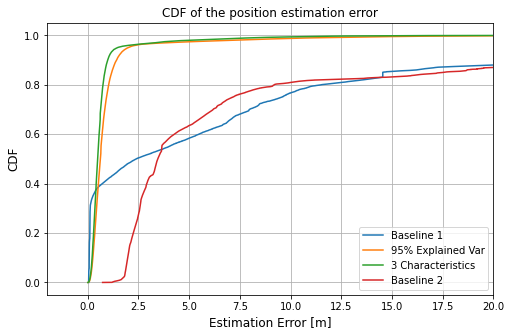

In [18]:
figure, ax = plt.subplots(1, 1, figsize=(8, 5)) 
ax.plot(np.sort(baseline_error), np.linspace(0,1,tot_points), np.sort(all_error_95), np.linspace(0,1,len(all_error_95)), 
       np.sort(all_error_3), np.linspace(0,1,len(all_error_3)), np.sort(hashim_baseline), np.linspace(0,1,len(hashim_baseline)))
tikzplotlib.clean_figure(fig=figure, target_resolution=600)

#plt.plot(np.sort(baseline_error), np.linspace(0,1,tot_points), linewidth=2, label="Baseline")
#plt.plot(np.sort(all_error), np.linspace(0,1,len(all_error)), linewidth=2, label="Min Delay")
#plt.plot(np.sort(all_error_all_paths), np.linspace(0,1,len(all_error_all_paths)), linewidth=2, label="All Paths")

plt.xlim([-2,20])
plt.ylabel("CDF", fontsize=12)
plt.xlabel("Estimation Error [m]", fontsize=12)
plt.title("CDF of the position estimation error")
plt.grid()
plt.legend(["Baseline 1", "95% Explained Var", "3 Characteristics", "Baseline 2"], loc="lower right")

tikzplotlib.save("./figures/pca_95_3charac_vs_baselines.tex")
# plt.savefig("./dnn_vs_baseline.png")

In [19]:
# print(f"The average error for the Baseline is {np.mean(baseline_error)}")
# print(f"The average error for Hashim Baseline is {np.mean(hashim_baseline)}")
# print(f"The average error for the Min Delay DNN is {np.mean(all_error)}")
# print(f"The average error for the All Paths DNN is {np.mean(all_error_all_paths)}")

In [20]:
baseline_err_sort = np.sort(baseline_error)
y = np.linspace(0,1.0,len(baseline_err_sort))
print(f"BASELINE 1: the 80% percentile error in meters is {baseline_err_sort[y>=0.8][0]}")

baseline_hash_sort = np.sort(hashim_baseline)
y = np.linspace(0,1.0,len(baseline_hash_sort))
print(f"BASELINE 2: the 80% percentile error in meters is {baseline_hash_sort[y>=0.8][0]}")

all_error_95_sort = np.sort(all_error_95)
y = np.linspace(0,1.0,len(all_error_95_sort))
print(f"95% Explained: the 80% percentile error in meters is {all_error_95_sort[y>=0.8][0]}")

all_error_3_sort = np.sort(all_error_3)
y = np.linspace(0,1.0,len(all_error_3_sort))
print(f"3 CHARACT: the 80% percentile error in meters is {all_error_3_sort[y>=0.8][0]}")


BASELINE 1: the 80% percentile error in meters is 11.510478518139134
BASELINE 2: the 80% percentile error in meters is 9.194424085538204
95% Explained: the 80% percentile error in meters is 1.0349042415618896
3 CHARACT: the 80% percentile error in meters is 0.7553972601890564
